## Cross-Shelf Transport - Diffusivity effects

This notebook explores the effects of changing the diapycnal diffusivity on the cross-shelf transport of tracers .

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
#Exp
CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
#CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)

#CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
#CGridNoCOut = Dataset(CGridNoC)


In [111]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =18, 3D = 4, total = 22)

rc = CGridOut.variables['RC']

xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
drC = CGridOut.variables['drC'] # vertical distance between centers

labels = ['Kv_out=1E-7, Kv_in=1E-3, Kiso = 1','Kv_out=1E-7, Kv_in=1E-4, Kiso = 1','Kv_out=1E-5, Kv_in=1E-3, Kiso = 1',
          'Kv_out=1E-5, Kv_in=1E-4, Kiso = 1','Kv=1E-5, Kiso = 1','Kv=1E-4, Kiso = 1','Kv=1E-3, Kiso = 1','Kv=3.8E-5, Kiso = 10'
          ,'Kv=2.8E-5, Kiso = 10','Kv=1.3E-5, Kiso = 10','Kv_noc=1E-5, Kiso = 1','Kv_noc=1E-4, Kiso = 1','Kv_noc=1E-3, Kiso = 1',
         'Kv=1E-5, Kiso = 10','Kv=1E-4, Kiso = 10','Kv=1E-3, Kiso = 10','Kv=1E-5, Kiso = 0.1','Kv=1E-4, Kiso = 0.1',
          'Kv=1E-3, Kiso = 0.1','Kv=3.8E-5, Kiso = 1','Kv=2.8E-5, Kiso = 1','Kv=1.3E-5, Kiso = 1']

times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [112]:
def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


In [113]:
# Just to know what's in there...
df = pd.read_csv('results/metricsDataFrames/CNTDIFF_CSTRANS_run03Tr2.csv')
df.head(1)

,Unnamed: 0,day,CS1,CS2,CS3,CS3sb,CS4,CS5,AS1,AS2,LID1,LID2
0,0,0.5,-0.255313,-0.684843,6.053521,0.585201,-4.643782,-0.226209,31.498585,37.769226,0.10978,0.540488


In [114]:
# load initial profiles

tracers_3D = ['04','05','06','07'] #run number because there's only 1 tr per run
tracers_CNT03 = ['1','2','3'] # tracer number , constant runs
tracers_CNT09 = ['1','2','3'] # tracer number , average diffusivity runs Kiso=1
tracers_CNT07 = ['1','2','3'] # tracer number , no canyon case
tracers_CNT02 = ['1','2','3'] # tracer number , Kiso=10
tracers_CNT04 = ['1','2','3'] # tracer number , Kiso=0.1
tracers_CNT10 = ['1','2','3'] # tracer number , Kiso=0.1

CS1 = np.zeros((nt-1,numTr)) 
CS2 = np.zeros((nt-1,numTr)) 
CS3 = np.zeros((nt-1,numTr)) 
CS4 = np.zeros((nt-1,numTr)) 
CS5 = np.zeros((nt-1,numTr)) 
CS3sb = np.zeros((nt-1,numTr)) 
AS1 = np.zeros((nt-1,numTr)) 
AS2 = np.zeros((nt-1,numTr)) 
LID1 = np.zeros((nt-1,numTr)) 
LID2 = np.zeros((nt-1,numTr)) 

kk = 0

fields = ['CS1','CS2','CS3','CS3sb','CS4','CS5','AS1' ,'AS2','LID1' ,'LID2']

for ii in tracers_3D:
    
    CS1[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[0] )
    CS2[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[1] )
    CS3[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[2] )
    CS3sb[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[3] )
    CS4[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[4] )
    CS5[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[5] )
    AS1[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[6] )
    AS2[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[7] )
    LID1[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[8] )
    LID2[:,kk] = get_metrics('3DDIFF_CSTRANS_', ii, '1', fields[9] )
    
    kk=kk+1
    

for ii in tracers_CNT03:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '03', ii, fields[9] )
    
    kk=kk+1

for ii in tracers_CNT09:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '09', ii, fields[9] )
      
    kk=kk+1

for ii in tracers_CNT07:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '07', ii, fields[9] )
      
    kk=kk+1

for ii in tracers_CNT02:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '02', ii, fields[9] )
    
    kk=kk+1

for ii in tracers_CNT04:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '04', ii, fields[9] )
    
    kk=kk+1

for ii in tracers_CNT10:
    
    CS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[0] )
    CS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[1] )
    CS3[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[2] )
    CS3sb[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[3] )
    CS4[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[4] )
    CS5[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[5] )
    AS1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[6] )
    AS2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[7] )
    LID1[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[8] )
    LID2[:,kk] = get_metrics('CNTDIFF_CSTRANS_', '10', ii, fields[9] )
    
    kk=kk+1


kk

22

## Definition of sections 

Different sections are defined to cover the whole shelf, and transports are sliced across them. There is  ane xtra section, not shown below, parallel to CS3 but leveled with the shelf break if the shelf was flat (yc[227,x]). It is named CS3sb.

<img src="figs/CrossShelfPlanes.png">

### Changing constant diffusivity without canyon

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


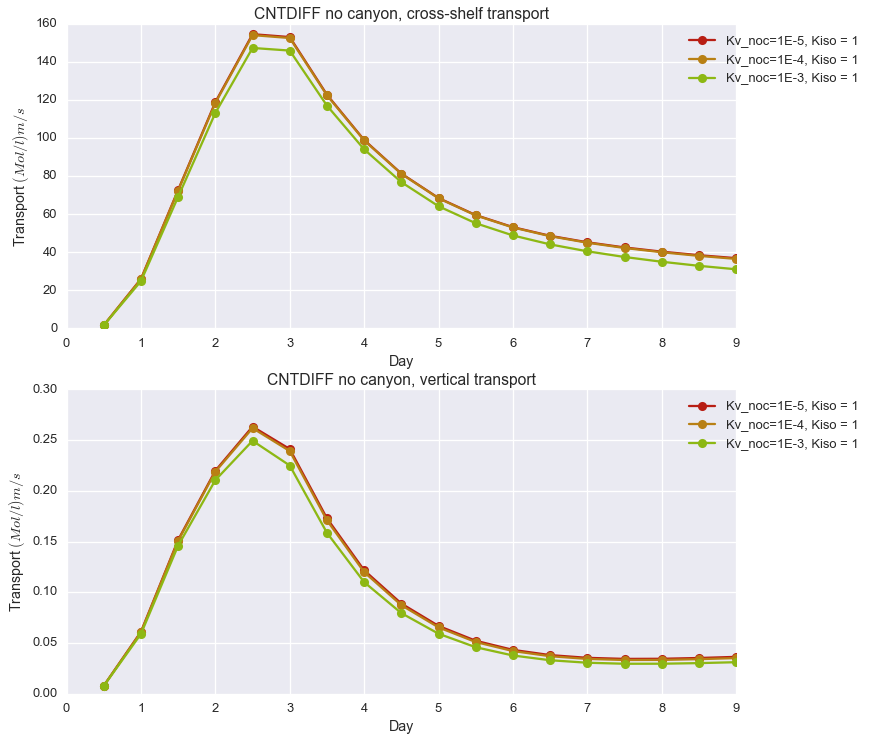

In [9]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

vertical1 =LID1[:,10] + LID2[:,10] 
total1 =  - AS1[:,10] + AS2[:,10] + CS1[:,10] + CS2[:,10] + CS3sb[:,10] + CS4[:,10] + CS5[:,10]
vertical2 =LID1[:,11] + LID2[:,11] 
total2 = - AS1[:,11] + AS2[:,11] + CS1[:,11] + CS2[:,11] + CS3sb[:,11] + CS4[:,11] + CS5[:,11]
vertical3 =LID1[:,12] + LID2[:,12] 
total3 = - AS1[:,12] + AS2[:,12] + CS1[:,12] + CS2[:,12] + CS3sb[:,12] + CS4[:,12] + CS5[:,12]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1,'o-', label = labels[10])
ax1.plot(times[1:]/2.0, total2,'o-', label = labels[11])
ax1.plot(times[1:]/2.0, total3,'o-', label = labels[12])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF no canyon, cross-shelf transport')


ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1,'o-', label = labels[10])
ax1.plot(times[1:]/2.0, vertical2,'o-', label = labels[11])
ax1.plot(times[1:]/2.0, vertical3,'o-', label = labels[12])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF no canyon, vertical transport')

#fig45.savefig('results/figures/CStransport/CSTransportCNTNoC_3Tr_difference.eps', format='eps', dpi=1000, bbox_inches='tight')


### Relative magnitude of each transect's transport w.r.t. no canyon case.

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


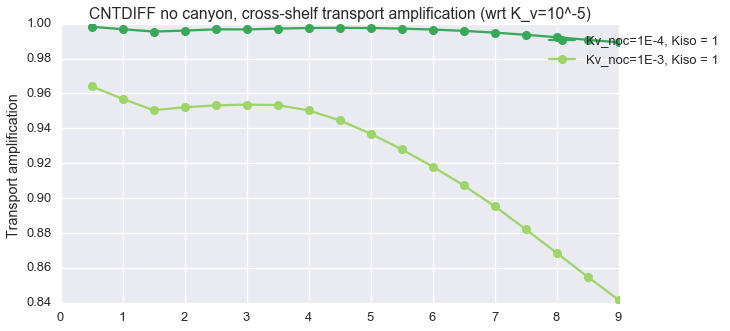

In [10]:
sns.set_palette('RdYlGn_r') 
means = np.zeros((2,2))

fig45=plt.figure(figsize=(10,5))

vertical1 =LID1[:,10] + LID2[:,10] 
total1 =  - AS1[:,10] + AS2[:,10] + CS1[:,10] + CS2[:,10] + CS3sb[:,10] + CS4[:,10] + CS5[:,10]
vertical2 =LID1[:,11] + LID2[:,11] 
total2 = - AS1[:,11] + AS2[:,11] + CS1[:,11] + CS2[:,11] + CS3sb[:,11] + CS4[:,11] + CS5[:,11]
vertical3 =LID1[:,12] + LID2[:,12] 
total3 = - AS1[:,12] + AS2[:,12] + CS1[:,12] + CS2[:,12] + CS3sb[:,12] + CS4[:,12] + CS5[:,12]

ax1 = plt.subplot(1,1,1)
ax1.plot(times[1:]/2.0, total2/total1,'o-', label = labels[11])
ax1.plot(times[1:]/2.0, total3/total1,'o-', label = labels[12])

means[0,0] = np.mean(total2[:10]/total1[:10])
means[1,0] = np.mean(total3[:10]/total1[:10])
means[0,1] = np.std(total2[10:]/total1[10:])
means[1,1] = np.std(total3[10:]/total1[10:])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport amplification ')
plt.title('CNTDIFF no canyon, cross-shelf transport amplification (wrt K_v=10^-5)')


#fig45.savefig('results/figures/CStransport/CSTransportCNTNoC_3Tr_Amplification.eps', format='eps', dpi=1000, bbox_inches='tight')


In [11]:
means





array([[ 0.99699926,  0.0026677 ],
       [ 0.95153757,  0.02867978]])

### Canyon case - changing vertical diffusivity

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


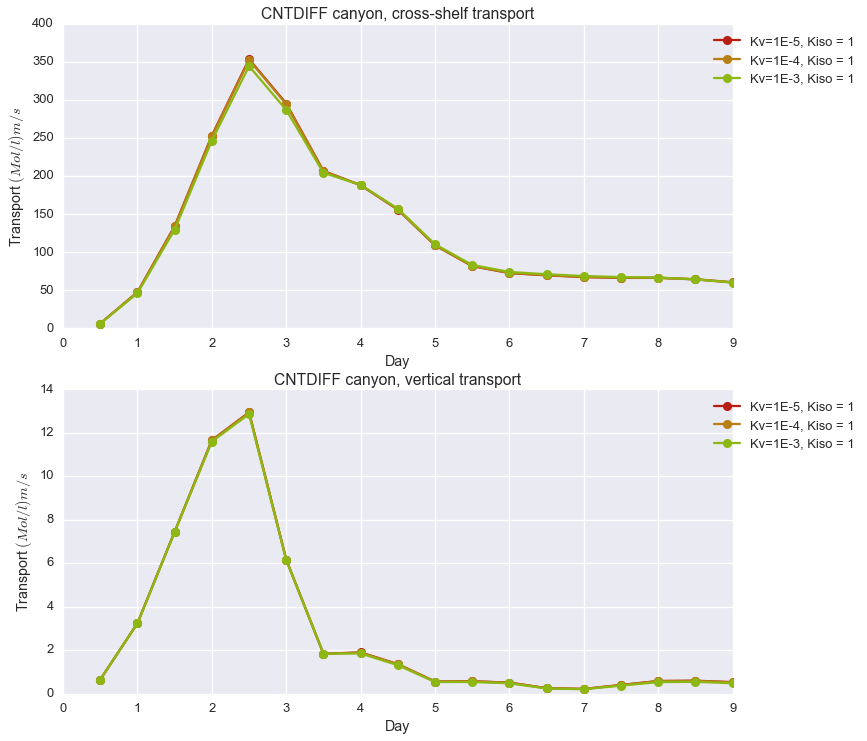

In [12]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

vertical1 =LID1[:,4] + LID2[:,4] 
total1 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical2 =LID1[:,5] + LID2[:,5] 
total2 = - AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]
vertical3 =LID1[:,6] + LID2[:,6] 
total3 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, total2,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total3,'o-', label = labels[6])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon, cross-shelf transport')


ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, vertical2,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, vertical3,'o-', label = labels[6])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon, vertical transport')

#fig45.savefig('results/figures/CStransport/CSTransportCNT_3Tr_difference.eps', format='eps', dpi=1000, bbox_inches='tight')


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


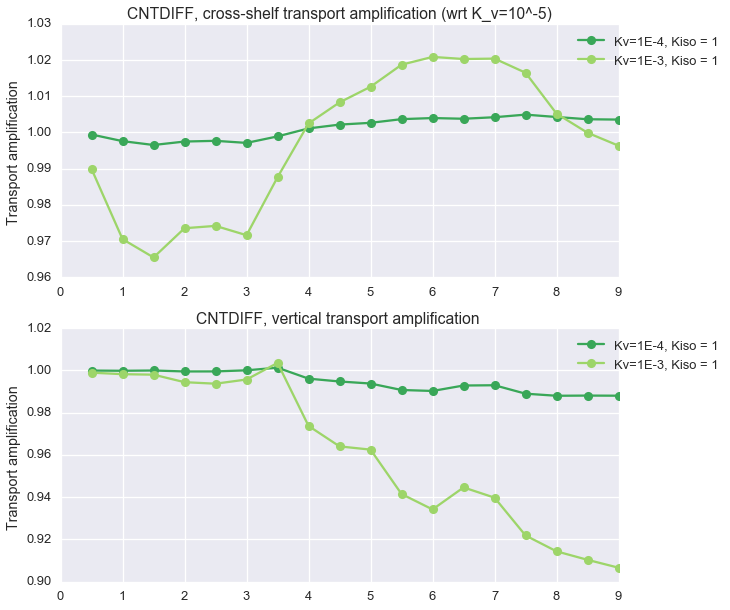

In [13]:
sns.set_palette('RdYlGn_r') 
means = np.zeros((4,2))

fig45=plt.figure(figsize=(10,10))

vertical1 =LID1[:,4] + LID2[:,4] 
total1 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical2 =LID1[:,5] + LID2[:,5] 
total2 = - AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]
vertical3 =LID1[:,6] + LID2[:,6] 
total3 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total2/total1,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total3/total1,'o-', label = labels[6])

means[0,0] = np.mean(total2[:10]/total1[:10])
means[1,0] = np.mean(total3[:10]/total1[:10])
means[0,1] = np.std(total2[10:]/total1[10:])
means[1,1] = np.std(total3[10:]/total1[10:])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport amplification ')
plt.title('CNTDIFF, cross-shelf transport amplification (wrt K_v=10^-5)')

ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical2/vertical1,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, vertical3/vertical1,'o-', label = labels[6])

means[2,0] = np.mean(vertical2[:10]/vertical1[:10])
means[3,0] = np.mean(vertical3[:10]/vertical1[:10])
means[2,1] = np.std(vertical2[10:]/vertical1[10:])
means[3,1] = np.std(vertical3[10:]/vertical1[10:])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport amplification ')
plt.title('CNTDIFF, vertical transport amplification ')


fig45.savefig('results/figures/CStransport/CSTransportCNT_3Tr_Amplification.eps', format='eps', dpi=1000, bbox_inches='tight')


In [14]:
means

array([[  9.99057146e-01,   4.24269904e-04],
       [  9.85628946e-01,   9.47966554e-03],
       [  9.98438924e-01,   1.94202938e-03],
       [  9.88246286e-01,   1.41942762e-02]])

### Canyon - no canyon for different diffusivities

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


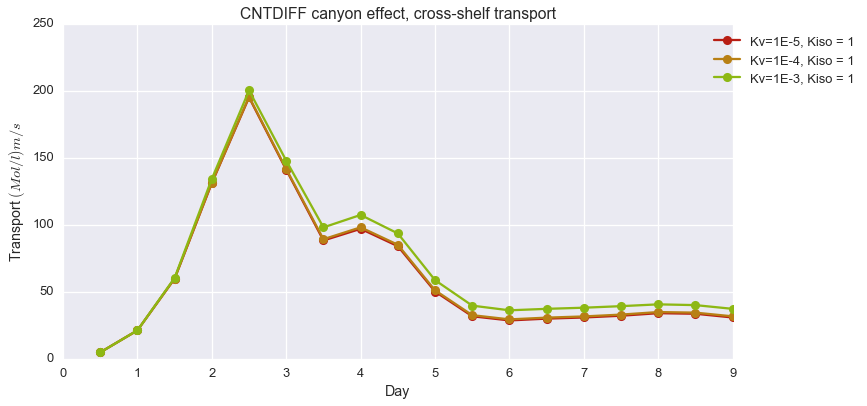

In [15]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,6))

vertical1 =LID1[:,4] + LID2[:,4] -(LID1[:,10] + LID2[:,10])
total1 =  (- AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]-
           (- AS1[:,10] + AS2[:,10] + CS1[:,10] + CS2[:,10] + CS3[:,10] + CS4[:,10] + CS5[:,10]))
vertical2 = LID1[:,5] + LID2[:,5] - (LID1[:,11] + LID2[:,11])
total2 = (- AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]-
          (- AS1[:,11] + AS2[:,11] + CS1[:,11] + CS2[:,11] + CS3[:,11] + CS4[:,11] + CS5[:,11]))
vertical3 =LID1[:,6] + LID2[:,6]-(LID1[:,12] + LID2[:,12]) 
total3 = (- AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]-
          (- AS1[:,12] + AS2[:,12] + CS1[:,12] + CS2[:,12] + CS3[:,12] + CS4[:,12] + CS5[:,12]))

ax1 = plt.subplot(1,1,1)
ax1.plot(times[1:]/2.0, total1,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, total2,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total3,'o-', label = labels[6])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon effect, cross-shelf transport')

#fig45.savefig('results/figures/CStransport/CSTransportCNT_3Tr_DifferenceNoC.eps', format='eps', dpi=1000, bbox_inches='tight')


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


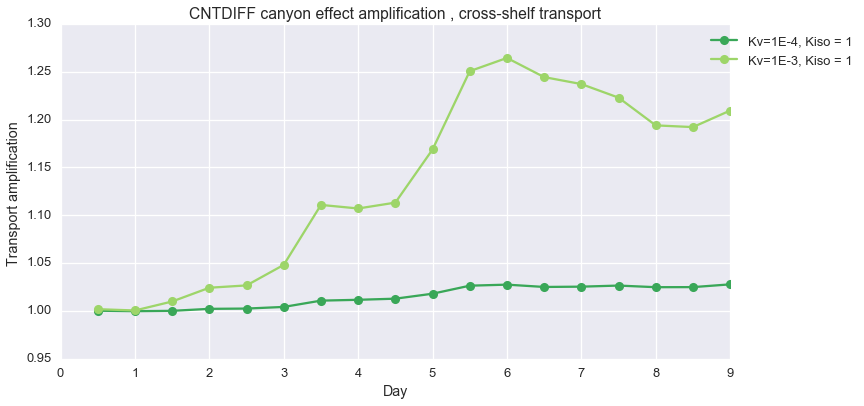

In [16]:
sns.set_palette('RdYlGn_r') 

fig45=plt.figure(figsize=(12,6))
means = np.zeros((2,2))
total1 =  (- AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]-
           (- AS1[:,10] + AS2[:,10] + CS1[:,10] + CS2[:,10] + CS3[:,10] + CS4[:,10] + CS5[:,10]))
total2 = (- AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]-
          (- AS1[:,11] + AS2[:,11] + CS1[:,11] + CS2[:,11] + CS3[:,11] + CS4[:,11] + CS5[:,11]))
total3 = (- AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]-
          (- AS1[:,12] + AS2[:,12] + CS1[:,12] + CS2[:,12] + CS3[:,12] + CS4[:,12] + CS5[:,12]))

ax1 = plt.subplot(1,1,1)
ax1.plot(times[1:]/2.0, total2/total1,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total3/total1,'o-', label = labels[6])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Transport amplification ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon effect amplification , cross-shelf transport')

means[0,0] = np.mean(total2[:10]/total1[:10])
means[1,0] = np.mean(total3[:10]/total1[:10])
means[0,1] = np.std(total2[10:]/total1[10:])
means[1,1] = np.std(total3[10:]/total1[10:])

#fig45.savefig('results/figures/CStransport/CSTransportCNT_3Tr_DifferenceNoCAmpl.eps', format='eps', dpi=1000, bbox_inches='tight')


In [17]:
means

array([[ 1.00614801,  0.00110124],
       [ 1.06105771,  0.02499352]])

### Changing geography of mixing

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


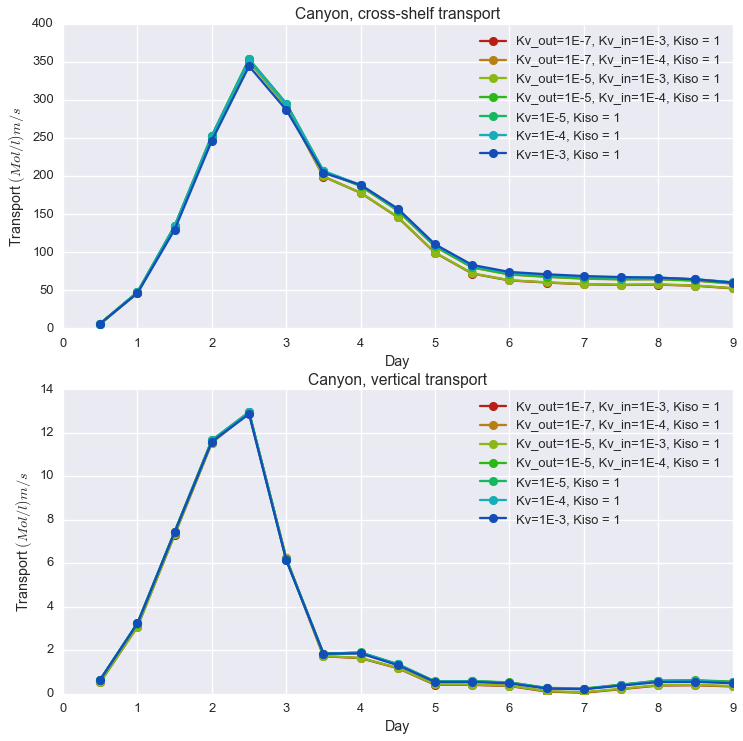

In [18]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

vertical1 =LID1[:,0] + LID2[:,0] 
total1 =  - AS1[:,0] + AS2[:,0] + CS1[:,0] + CS2[:,0] + CS3[:,0] + CS4[:,0] + CS5[:,0]
vertical2 =LID1[:,1] + LID2[:,1] 
total2 = - AS1[:,1] + AS2[:,1] + CS1[:,1] + CS2[:,1] + CS3[:,1] + CS4[:,1] + CS5[:,1]
vertical3 =LID1[:,2] + LID2[:,2] 
total3 = - AS1[:,2] + AS2[:,2] + CS1[:,2] + CS2[:,2] + CS3[:,2] + CS4[:,2] + CS5[:,2]
vertical4 =LID1[:,3] + LID2[:,3] 
total4 = - AS1[:,3] + AS2[:,3] + CS1[:,3] + CS2[:,3] + CS3[:,3] + CS4[:,3] + CS5[:,3]
vertical5 =LID1[:,4] + LID2[:,4] 
total5 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical6 =LID1[:,5] + LID2[:,5] 
total6 = - AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]
vertical7 =LID1[:,6] + LID2[:,6] 
total7 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]


ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, total2,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, total3,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, total4,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, total5,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, total6,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total7,'o-', label = labels[6])


plt.legend(loc=0)
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('Canyon, cross-shelf transport')


ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, vertical2,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, vertical3,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, vertical4,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, vertical5,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, vertical6,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, vertical7,'o-', label = labels[6])

plt.legend(loc=0)
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('Canyon, vertical transport')

fig45.savefig('results/figures/CStransport/CSTransport3DnCNT_7Tr.eps', format='eps', dpi=1000, bbox_inches='tight')


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


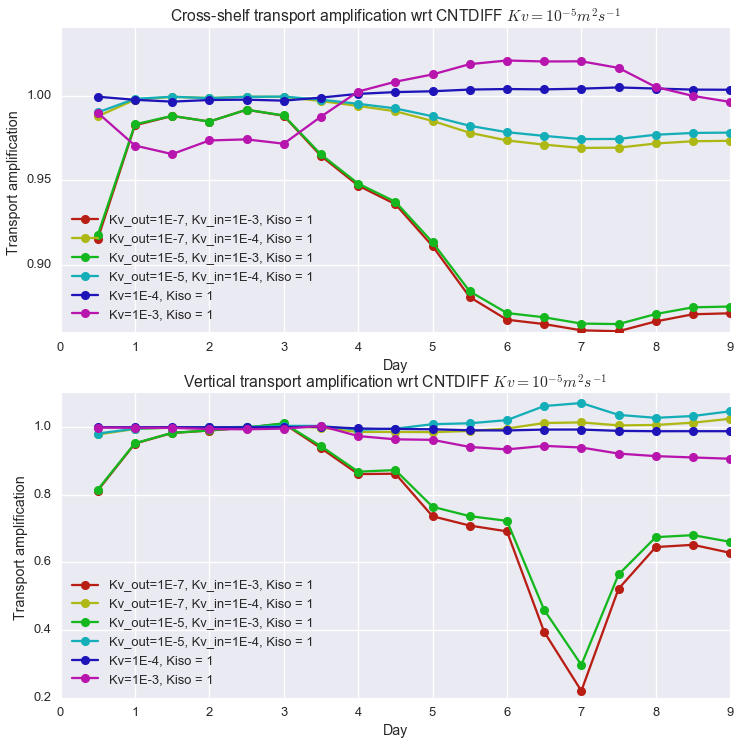

In [19]:
#sns.set_palette('RdYlGn_r') 
sns.set_palette( sns.hls_palette(6, l=.4, s=.8)) 
fig45=plt.figure(figsize=(12,12))
means = np.zeros((2,12))

vertical1 =LID1[:,0] + LID2[:,0] 
total1 =  - AS1[:,0] + AS2[:,0] + CS1[:,0] + CS2[:,0] + CS3[:,0] + CS4[:,0] + CS5[:,0]
vertical2 =LID1[:,1] + LID2[:,1] 
total2 = - AS1[:,1] + AS2[:,1] + CS1[:,1] + CS2[:,1] + CS3[:,1] + CS4[:,1] + CS5[:,1]
vertical3 =LID1[:,2] + LID2[:,2] 
total3 = - AS1[:,2] + AS2[:,2] + CS1[:,2] + CS2[:,2] + CS3[:,2] + CS4[:,2] + CS5[:,2]
vertical4 =LID1[:,3] + LID2[:,3] 
total4 = - AS1[:,3] + AS2[:,3] + CS1[:,3] + CS2[:,3] + CS3[:,3] + CS4[:,3] + CS5[:,3]
vertical5 =LID1[:,4] + LID2[:,4] 
total5 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical6 =LID1[:,5] + LID2[:,5] 
total6 = - AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]
vertical7 =LID1[:,6] + LID2[:,6] 
total7 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1/total5,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, total2/total5,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, total3/total5,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, total4/total5,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, total6/total5,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, total7/total5,'o-', label = labels[6])

plt.legend(loc=0)
plt.ylabel('Transport amplification ')
plt.xlabel('Day')
plt.title('Cross-shelf transport amplification wrt CNTDIFF $Kv=10^{-5}m^2s^{-1}$')

means[0,0] = np.mean(total1[:10]/total5[:10])
means[0,1] = np.mean(total2[:10]/total5[:10])
means[1,0] = np.std(total1[10:]/total5[10:])
means[1,1] = np.std(total2[10:]/total5[10:])
means[0,2] = np.mean(total3[:10]/total5[:10])
means[0,3] = np.mean(total4[:10]/total5[:10])
means[1,2] = np.std(total3[10:]/total5[10:])
means[1,3] = np.std(total4[10:]/total5[10:])
means[0,4] = np.mean(total6[:10]/total5[:10])
means[0,5] = np.mean(total7[:10]/total5[:10])
means[1,4] = np.std(total7[10:]/total5[10:])
means[1,5] = np.std(total7[10:]/total5[10:])

ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1/vertical5,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, vertical2/vertical5,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, vertical3/vertical5,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, vertical4/vertical5,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, vertical6/vertical5,'o-', label = labels[5])
ax1.plot(times[1:]/2.0, vertical7/vertical5,'o-', label = labels[6])

plt.legend(loc=0)
plt.ylabel('Transport amplification ')
plt.xlabel('Day')
plt.title('Vertical transport amplification wrt CNTDIFF $Kv=10^{-5}m^2s^{-1}$')

means[0,6] = np.mean(vertical1[:10]/vertical5[:10])
means[0,7] = np.mean(vertical2[:10]/vertical5[:10])
means[1,6] = np.std(vertical1[10:]/vertical5[10:])
means[1,7] = np.std(vertical2[10:]/vertical5[10:])
means[0,8] = np.mean(vertical3[:10]/vertical5[:10])
means[0,9] = np.mean(vertical4[:10]/vertical5[:10])
means[1,8] = np.std(vertical3[10:]/vertical5[10:])
means[1,9] = np.std(vertical4[10:]/vertical5[10:])
means[0,10] = np.mean(vertical6[:10]/vertical5[:10])
means[0,11] = np.mean(vertical7[:10]/vertical5[:10])
means[1,10] = np.std(vertical6[10:]/vertical5[10:])
means[1,11] = np.std(vertical7[10:]/vertical5[10:])


#fig45.savefig('results/figures/CStransport/CSTransportAmplwrt1E_5.eps', format='eps', dpi=1000, bbox_inches='tight')


In [20]:
print(means[0,:])
print(means[1,:])

[ 0.96086961  0.99489497  0.96175597  0.99584021  0.99905715  0.98562895
  0.9144084   0.992956    0.92015452  0.99794035  0.99843892  0.98824629]
[ 0.00607429  0.00268611  0.00587476  0.0023614   0.00947967  0.00947967
  0.15978756  0.01052118  0.14247903  0.01910716  0.00194203  0.01419428]


### Checking if it's the geography of mixing or the average diffusivity of that case

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


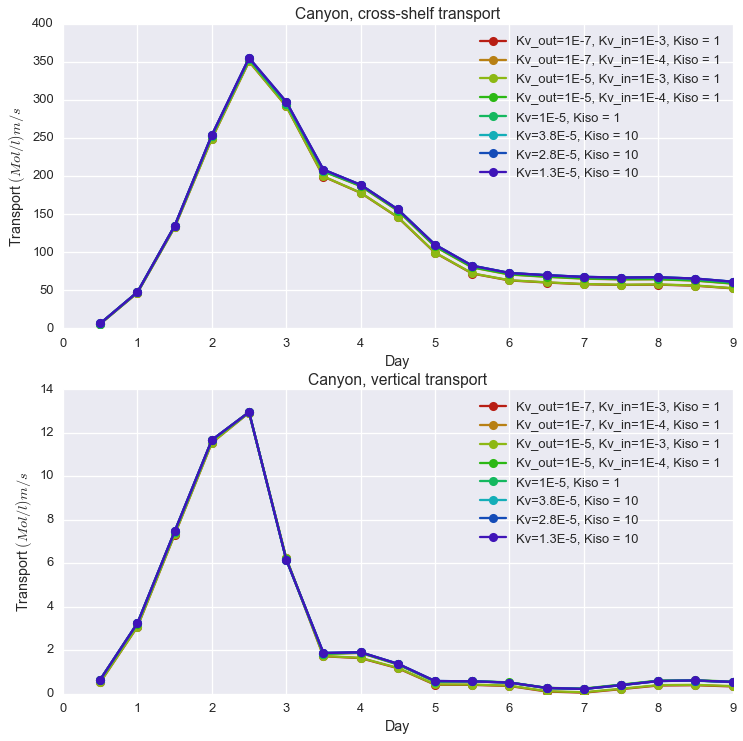

In [21]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

vertical1 =LID1[:,0] + LID2[:,0] 
total1 =  - AS1[:,0] + AS2[:,0] + CS1[:,0] + CS2[:,0] + CS3[:,0] + CS4[:,0] + CS5[:,0]
vertical2 =LID1[:,1] + LID2[:,1] 
total2 = - AS1[:,1] + AS2[:,1] + CS1[:,1] + CS2[:,1] + CS3[:,1] + CS4[:,1] + CS5[:,1]
vertical3 =LID1[:,2] + LID2[:,2] 
total3 = - AS1[:,2] + AS2[:,2] + CS1[:,2] + CS2[:,2] + CS3[:,2] + CS4[:,2] + CS5[:,2]
vertical4 =LID1[:,3] + LID2[:,3] 
total4 = - AS1[:,3] + AS2[:,3] + CS1[:,3] + CS2[:,3] + CS3[:,3] + CS4[:,3] + CS5[:,3]
vertical5 =LID1[:,4] + LID2[:,4] 
total5 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical6 =LID1[:,7] + LID2[:,7] 
total6 = - AS1[:,7] + AS2[:,7] + CS1[:,7] + CS2[:,7] + CS3[:,7] + CS4[:,7] + CS5[:,7]
vertical7 =LID1[:,8] + LID2[:,8] 
total7 = - AS1[:,8] + AS2[:,8] + CS1[:,8] + CS2[:,8] + CS3[:,8] + CS4[:,8] + CS5[:,8]
vertical8 =LID1[:,9] + LID2[:,9] 
total8 = - AS1[:,9] + AS2[:,9] + CS1[:,9] + CS2[:,9] + CS3[:,9] + CS4[:,9] + CS5[:,9]

ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, total2,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, total3,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, total4,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, total5,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, total6,'o-', label = labels[7])
ax1.plot(times[1:]/2.0, total7,'o-', label = labels[8])
ax1.plot(times[1:]/2.0, total8,'o-', label = labels[9])

plt.legend(loc=0)
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('Canyon, cross-shelf transport')

ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, vertical2,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, vertical3,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, vertical4,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, vertical5,'o-', label = labels[4])
ax1.plot(times[1:]/2.0, vertical6,'o-', label = labels[7])
ax1.plot(times[1:]/2.0, vertical7,'o-', label = labels[8])
ax1.plot(times[1:]/2.0, vertical8,'o-', label = labels[9])

plt.legend(loc=0)
plt.ylabel('Transport $(Mol/l) m/s$ ')
plt.xlabel('Day')
plt.title('Canyon, vertical transport')

#fig45.savefig('results/figures/CStransport/CSTransport3DnAVG.eps', format='eps', dpi=1000, bbox_inches='tight')


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


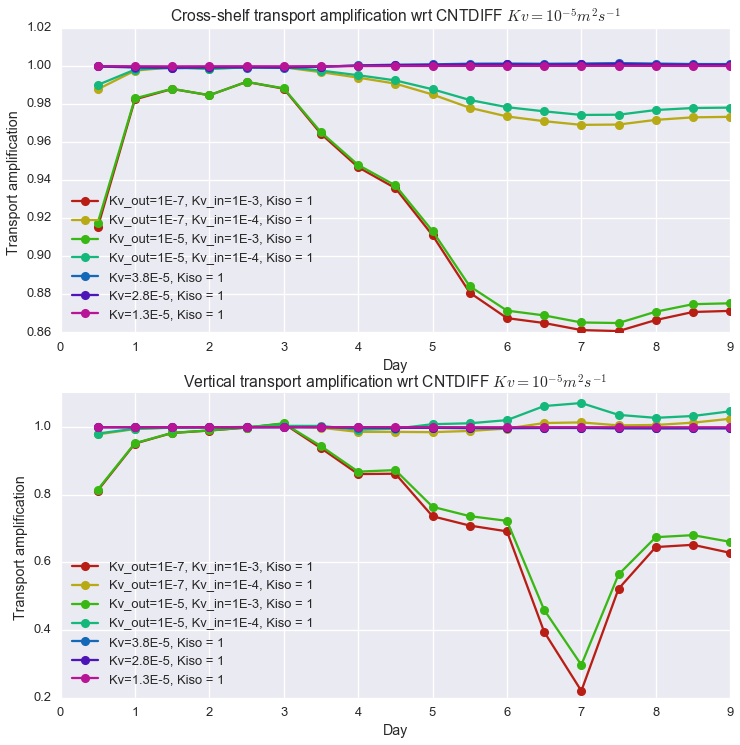

In [115]:
#sns.set_palette('RdYlGn_r') 
sns.set_palette( sns.hls_palette(7, l=.4, s=.8)) 
fig45=plt.figure(figsize=(12,12))
means = np.zeros((2,13))

vertical1 =LID1[:,0] + LID2[:,0] 
total1 =  - AS1[:,0] + AS2[:,0] + CS1[:,0] + CS2[:,0] + CS3[:,0] + CS4[:,0] + CS5[:,0]
vertical2 =LID1[:,1] + LID2[:,1] 
total2 = - AS1[:,1] + AS2[:,1] + CS1[:,1] + CS2[:,1] + CS3[:,1] + CS4[:,1] + CS5[:,1]
vertical3 =LID1[:,2] + LID2[:,2] 
total3 = - AS1[:,2] + AS2[:,2] + CS1[:,2] + CS2[:,2] + CS3[:,2] + CS4[:,2] + CS5[:,2]
vertical4 =LID1[:,3] + LID2[:,3] 
total4 = - AS1[:,3] + AS2[:,3] + CS1[:,3] + CS2[:,3] + CS3[:,3] + CS4[:,3] + CS5[:,3]
vertical5 =LID1[:,4] + LID2[:,4] 
total5 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical6 =LID1[:,19] + LID2[:,19] 
total6 = - AS1[:,19] + AS2[:,19] + CS1[:,19] + CS2[:,19] + CS3[:,19] + CS4[:,19] + CS5[:,19]
vertical7 =LID1[:,20] + LID2[:,20] 
total7 = - AS1[:,20] + AS2[:,20] + CS1[:,20] + CS2[:,20] + CS3[:,20] + CS4[:,20] + CS5[:,20]
vertical8 =LID1[:,21] + LID2[:,21] 
total8 = - AS1[:,21] + AS2[:,21] + CS1[:,21] + CS2[:,21] + CS3[:,21] + CS4[:,21] + CS5[:,21]


ax1 = plt.subplot(2,1,1)
ax1.plot(times[1:]/2.0, total1/total5,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, total2/total5,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, total3/total5,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, total4/total5,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, total6/total5,'o-', label = labels[19])
ax1.plot(times[1:]/2.0, total7/total5,'o-', label = labels[20])
ax1.plot(times[1:]/2.0, total8/total5,'o-', label = labels[21])

plt.legend(loc=0)
plt.ylabel('Transport amplification ')
plt.xlabel('Day')
plt.title('Cross-shelf transport amplification wrt CNTDIFF $Kv=10^{-5}m^2s^{-1}$')

means[0,0] = np.mean(total1[:10]/total5[:10])
means[0,1] = np.mean(total2[:10]/total5[:10])
means[1,0] = np.std(total1[10:]/total5[10:])
means[1,1] = np.std(total2[10:]/total5[10:])
means[0,2] = np.mean(total3[:10]/total5[:10])
means[0,3] = np.mean(total4[:10]/total5[:10])
means[1,2] = np.std(total3[10:]/total5[10:])
means[1,3] = np.std(total4[10:]/total5[10:])
means[0,4] = np.mean(total6[:10]/total5[:10])
means[0,5] = np.mean(total7[:10]/total5[:10])
means[1,4] = np.std(total7[10:]/total5[10:])
means[1,5] = np.std(total7[10:]/total5[10:])

ax1 = plt.subplot(2,1,2)
ax1.plot(times[1:]/2.0, vertical1/vertical5,'o-', label = labels[0])
ax1.plot(times[1:]/2.0, vertical2/vertical5,'o-', label = labels[1])
ax1.plot(times[1:]/2.0, vertical3/vertical5,'o-', label = labels[2])
ax1.plot(times[1:]/2.0, vertical4/vertical5,'o-', label = labels[3])
ax1.plot(times[1:]/2.0, vertical6/vertical5,'o-', label = labels[19])
ax1.plot(times[1:]/2.0, vertical7/vertical5,'o-', label = labels[20])
ax1.plot(times[1:]/2.0, vertical8/vertical5,'o-', label = labels[21])

plt.legend(loc=0)
plt.ylabel('Transport amplification ')
plt.xlabel('Day')
plt.title('Vertical transport amplification wrt CNTDIFF $Kv=10^{-5}m^2s^{-1}$')

means[0,6] = np.mean(vertical1[:10]/vertical5[:10])
means[0,7] = np.mean(vertical2[:10]/vertical5[:10])
means[1,6] = np.std(vertical1[10:]/vertical5[10:])
means[1,7] = np.std(vertical2[10:]/vertical5[10:])
means[0,8] = np.mean(vertical3[:10]/vertical5[:10])
means[0,9] = np.mean(vertical4[:10]/vertical5[:10])
means[1,8] = np.std(vertical3[10:]/vertical5[10:])
means[1,9] = np.std(vertical4[10:]/vertical5[10:])
means[0,10] = np.mean(vertical6[:10]/vertical5[:10])
means[0,11] = np.mean(vertical7[:10]/vertical5[:10])
means[1,10] = np.std(vertical6[10:]/vertical5[10:])
means[1,11] = np.std(vertical7[10:]/vertical5[10:])
means[1,12] = np.mean(vertical8[:10]/vertical5[:10])
means[0,12] = np.std(vertical8[:10]/vertical5[:10])


#fig45.savefig('results/figures/CStransport/CSTransportAmplwrt1E_5_AvgDiffs.eps', format='eps', dpi=1000, bbox_inches='tight')


In [116]:
Peh = np.zeros(19) # 13 tracers
Pev = np.zeros(19) # 13 tracers
K = np.zeros(19)

kd = np.array([1.E-3,1.E-4,1.E-3,1.E-4,1.E-5,1.E-4,1.E-3,(3.81)*1.E-5,(2.8)*1.E-5,(1.3)*1.E-5,
               1.E-5,1.E-4,1.E-3,1.E-5,1.E-4,1.E-3,1.E-5,1.E-4,1.E-3,(3.81)*1.E-5,(2.8)*1.E-5,(1.3)*1.E-5])

ki = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,1.0,1.0,1.0,10.0,10.0,10.0,0.1,0.1,0.1,1.0,1.0,1.0])

L = 6400.0 # meters
U = 6.60E-2 # ms−1 Barkley - change for mine
Z =21.7 # m Barkley - change for mine
Om = 2.23E-4 # Barkley - change for mine


Peh = (L*U)/ki
Pev = (Z*Om)/kd
K = (Z*Z*ki)/(L*L*kd)

print(Peh)
print(Pev)
print(K)

[  422.4    422.4    422.4    422.4    422.4    422.4    422.4     42.24
    42.24    42.24   422.4    422.4    422.4     42.24    42.24    42.24
  4224.    4224.    4224.     422.4    422.4    422.4 ]
[   4.8391       48.391         4.8391       48.391       483.91         48.391
    4.8391      127.01049869  172.825       372.23846154  483.91         48.391
    4.8391      483.91         48.391         4.8391      483.91         48.391
    4.8391      127.01049869  172.825       372.23846154]
[  1.14963379e-02   1.14963379e-01   1.14963379e-02   1.14963379e-01
   1.14963379e+00   1.14963379e-01   1.14963379e-02   3.01741152e+00
   4.10583496e+00   8.84333684e+00   1.14963379e+00   1.14963379e-01
   1.14963379e-02   1.14963379e+01   1.14963379e+00   1.14963379e-01
   1.14963379e-01   1.14963379e-02   1.14963379e-03   3.01741152e-01
   4.10583496e-01   8.84333684e-01]


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


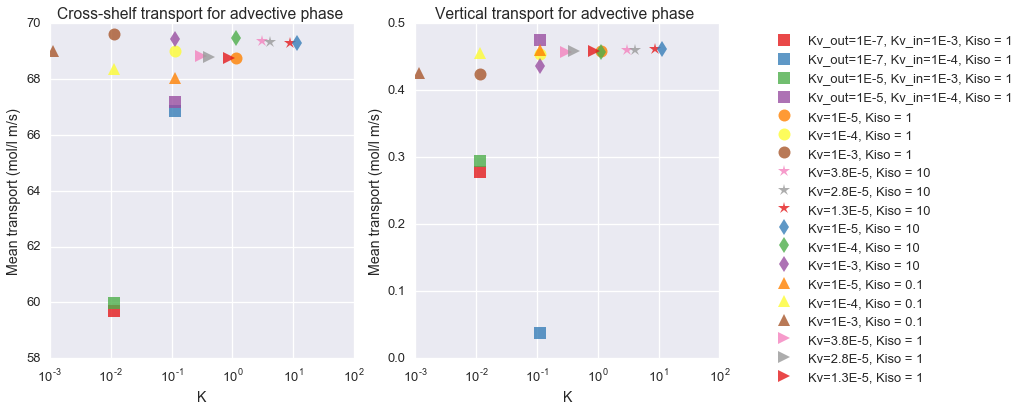

In [117]:
vertical1 =LID1[:,0] + LID2[:,0] 
total1 =  - AS1[:,0] + AS2[:,0] + CS1[:,0] + CS2[:,0] + CS3[:,0] + CS4[:,0] + CS5[:,0]
vertical2 =LID1[:,1] + LID2[:,1] 
total2 = - AS1[:,1] + AS2[:,1] + CS1[:,1] + CS2[:,1] + CS3[:,1] + CS4[:,1] + CS5[:,1]
vertical3 =LID1[:,2] + LID2[:,2] 
total3 = - AS1[:,2] + AS2[:,2] + CS1[:,2] + CS2[:,2] + CS3[:,2] + CS4[:,2] + CS5[:,2]
vertical4 =LID1[:,3] + LID2[:,3] 
total4 = - AS1[:,3] + AS2[:,3] + CS1[:,3] + CS2[:,3] + CS3[:,3] + CS4[:,3] + CS5[:,3]
vertical5 =LID1[:,4] + LID2[:,4] 
total5 =  - AS1[:,4] + AS2[:,4] + CS1[:,4] + CS2[:,4] + CS3[:,4] + CS4[:,4] + CS5[:,4]
vertical6 =LID1[:,5] + LID2[:,5] 
total6 = - AS1[:,5] + AS2[:,5] + CS1[:,5] + CS2[:,5] + CS3[:,5] + CS4[:,5] + CS5[:,5]
vertical7 =LID1[:,6] + LID2[:,6] 
total7 = - AS1[:,6] + AS2[:,6] + CS1[:,6] + CS2[:,6] + CS3[:,6] + CS4[:,6] + CS5[:,6]
vertical8 =LID1[:,7] + LID2[:,7] 
total8 = - AS1[:,7] + AS2[:,7] + CS1[:,7] + CS2[:,7] + CS3[:,7] + CS4[:,7] + CS5[:,7]
vertical9 =LID1[:,8] + LID2[:,8] 
total9 = - AS1[:,8] + AS2[:,8] + CS1[:,8] + CS2[:,8] + CS3[:,8] + CS4[:,8] + CS5[:,8]
vertical10 =LID1[:,9] + LID2[:,9] 
total10 = - AS1[:,9] + AS2[:,9] + CS1[:,9] + CS2[:,9] + CS3[:,9] + CS4[:,9] + CS5[:,9]
vertical11 =LID1[:,10] + LID2[:,10] 
total11 = - AS1[:,10] + AS2[:,10] + CS1[:,10] + CS2[:,10] + CS3[:,10] + CS4[:,10] + CS5[:,10]
vertical2 =LID1[:,11] + LID2[:,11] 
total12 = - AS1[:,11] + AS2[:,11] + CS1[:,11] + CS2[:,11] + CS3[:,11] + CS4[:,11] + CS5[:,11]
vertical13 =LID1[:,12] + LID2[:,12] 
total13 = - AS1[:,12] + AS2[:,12] + CS1[:,12] + CS2[:,12] + CS3[:,12] + CS4[:,12] + CS5[:,12]
vertical14 =LID1[:,13] + LID2[:,13] 
total14 = - AS1[:,13] + AS2[:,13] + CS1[:,13] + CS2[:,13] + CS3[:,13] + CS4[:,13] + CS5[:,13]
vertical15 =LID1[:,14] + LID2[:,14] 
total15 = - AS1[:,14] + AS2[:,14] + CS1[:,14] + CS2[:,14] + CS3[:,14] + CS4[:,14] + CS5[:,14]
vertical16 =LID1[:,15] + LID2[:,15] 
total16 = - AS1[:,15] + AS2[:,15] + CS1[:,15] + CS2[:,15] + CS3[:,15] + CS4[:,15] + CS5[:,15]
vertical17 =LID1[:,16] + LID2[:,16] 
total17 = - AS1[:,16] + AS2[:,16] + CS1[:,16] + CS2[:,16] + CS3[:,16] + CS4[:,16] + CS5[:,16]
vertical18 =LID1[:,17] + LID2[:,17] 
total18 = - AS1[:,17] + AS2[:,17] + CS1[:,17] + CS2[:,17] + CS3[:,17] + CS4[:,17] + CS5[:,17]
vertical19 =LID1[:,18] + LID2[:,18] 
total19 = - AS1[:,18] + AS2[:,18] + CS1[:,18] + CS2[:,18] + CS3[:,18] + CS4[:,18] + CS5[:,18]
vertical20 =LID1[:,19] + LID2[:,19] 
total20 = - AS1[:,19] + AS2[:,19] + CS1[:,19] + CS2[:,19] + CS3[:,19] + CS4[:,19] + CS5[:,19]
vertical21 =LID1[:,20] + LID2[:,20] 
total21 = - AS1[:,20] + AS2[:,20] + CS1[:,20] + CS2[:,20] + CS3[:,20] + CS4[:,20] + CS5[:,20]
vertical22 =LID1[:,21] + LID2[:,21] 
total22 = - AS1[:,21] + AS2[:,21] + CS1[:,21] + CS2[:,21] + CS3[:,21] + CS4[:,21] + CS5[:,21]

totalList = [total1, total2,total3,total4, total5,total6, total7,total8,total9, total10,total14,
             total15,total16,total17,total18,total19,total20,total21,total22]#,total11, total12, total13]
verticalList = [vertical1, vertical2,vertical3,vertical4, vertical5,vertical6, vertical7,vertical8,
                vertical9, vertical10,vertical14, vertical15, vertical16,vertical17, vertical18, vertical19,vertical20,
               vertical21,vertical22]#,vertical11, vertical12, vertical13]


indexList = [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj = 0  

sns.set_palette( 'Set1',len(totalList))
fig42=plt.figure(figsize=(12,6))

    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, totalList,verticalList):
    ax1 = plt.subplot(1,2,1)
    plt.plot(K[ii] , np.mean(tot[10:]),marker[jj],markersize=12,alpha=0.8,label = labels[ii])
    plt.ylabel('Mean transport (mol/l m/s)')
    plt.xlabel('K')
    plt.title('Cross-shelf transport for advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(K[ii] , np.mean(vert[10:]),marker[jj],markersize=12,alpha=0.8,label = labels[ii])
    plt.ylabel('Mean transport (mol/l m/s)')
    plt.xlabel('K')
    plt.title('Vertical transport for advective phase ')
    ax2.set_xscale("log", nonposy='clip')
    jj=jj+1
ax2.legend(loc ='upper right', bbox_to_anchor=(2,1))
#ax2.legend(loc =0)

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


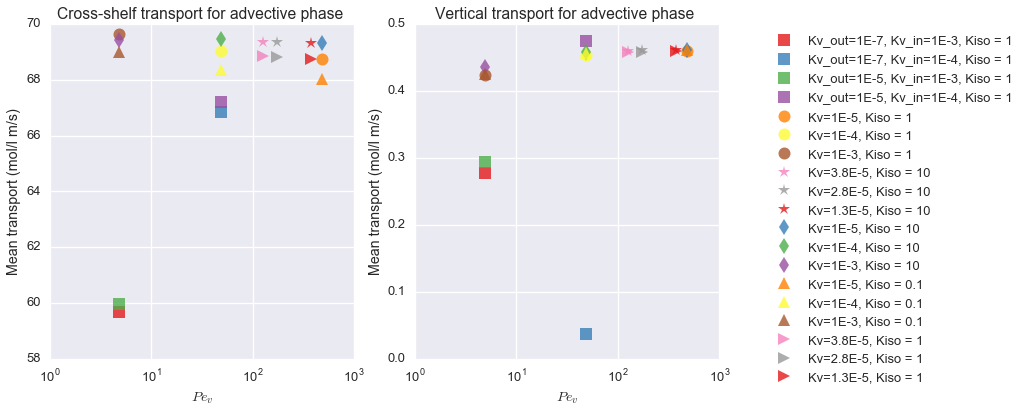

In [118]:
sns.set_palette( 'Set1',len(totalList))
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj = 0  
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, totalList,verticalList):
    ax1 = plt.subplot(1,2,1)
    plt.plot(Pev[ii] , np.mean(tot[10:]),marker[jj],markersize=12,alpha=0.8,label = labels[ii])
    plt.ylabel('Mean transport (mol/l m/s)')
    plt.xlabel('$Pe_v$')
    plt.title('Cross-shelf transport for advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(Pev[ii] , np.mean(vert[10:]),marker[jj],markersize=12,alpha=0.8,label = labels[ii])
    plt.ylabel('Mean transport (mol/l m/s)')
    plt.xlabel('$Pe_v$')
    plt.title('Vertical transport for advective phase ')
    ax2.set_xscale("log", nonposy='clip')
    jj = jj+1
ax2.legend(loc ='upper right', bbox_to_anchor=(2,1))
#ax2.legend(loc =0)

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


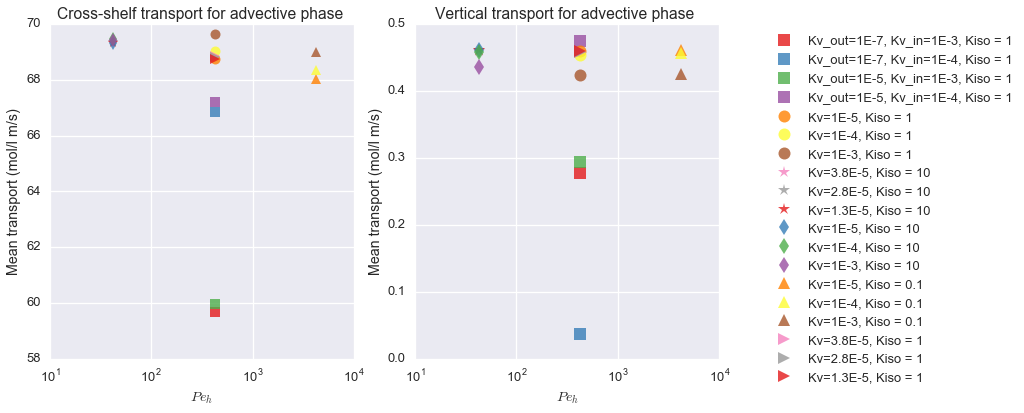

In [119]:
sns.set_palette( 'Set1',len(totalList))
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj=0
    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, totalList,verticalList):
    ax1 = plt.subplot(1,2,1)
    plt.plot(Peh[ii] , np.mean(tot[10:]),marker[jj], markersize = 10,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean transport (mol/l m/s)')
    plt.xlabel('$Pe_h$')
    plt.title('Cross-shelf transport for advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(Peh[ii] , np.mean(vert[10:]),marker[jj], markersize = 12,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean transport (mol/l m/s)')
    plt.xlabel('$Pe_h$')
    plt.title('Vertical transport for advective phase ')
    ax2.set_xscale("log", nonposy='clip')
    jj = jj+1
ax2.legend(loc ='upper right', bbox_to_anchor=(2,1))
#ax2.legend(loc =0)


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


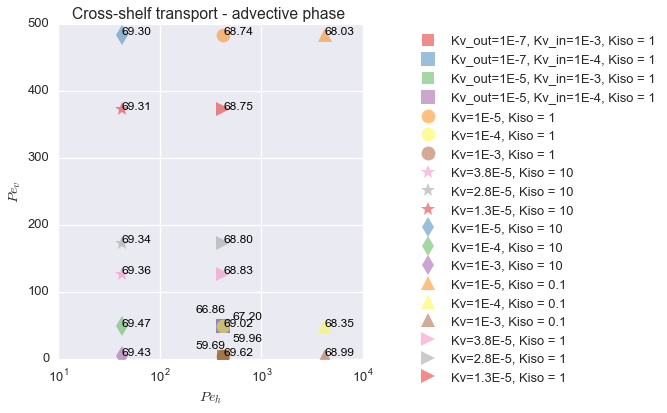

In [120]:
sns.set_palette( 'Set1',len(totalList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, totalList,verticalList):
    ax1 = plt.subplot(1,2,1)
    msize = (np.mean(tot[10:])/20)*4
    plt.plot(Peh[ii], Pev[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.5)
    
    strnum = ('%1.2f' %(np.mean(tot[10:])))
    if ii == 3:
        pl.text(Peh[ii]+100, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 2:
        pl.text(Peh[ii]+100, Pev[ii]+20, strnum, color="black", fontsize=12)
    elif ii == 0:
        pl.text(Peh[ii]-200, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 1:
        pl.text(Peh[ii]-200, Pev[ii]+20, strnum, color="black", fontsize=12)
    else:
        pl.text(Peh[ii], Pev[ii], strnum, color="black", fontsize=12)

    plt.ylabel('$Pe_v$')
    plt.xlabel('$Pe_h$')
    plt.title('Cross-shelf transport - advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    jj = jj+1
    
    
ax1.legend(loc ='upper right', bbox_to_anchor=(2,1))


    
plt.show()

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


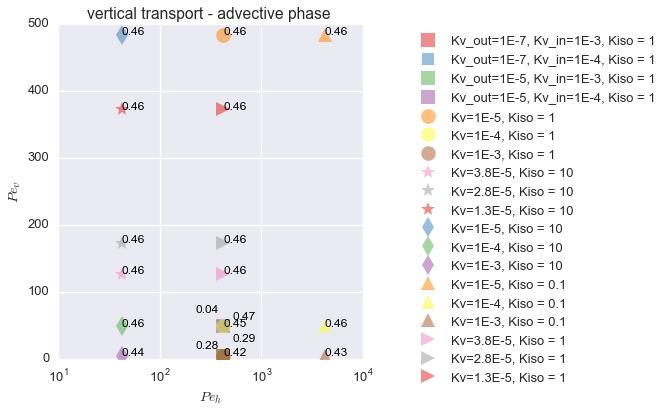

In [121]:
sns.set_palette( 'Set1',len(totalList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, totalList,verticalList):
    ax1 = plt.subplot(1,2,1)
    msize = (np.mean(vert[10:])+2.0)*6.0
    plt.plot(Peh[ii], Pev[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.5)
    
    strnum = ('%1.2f' %(np.mean(vert[10:])))
    if ii == 3:
        pl.text(Peh[ii]+100, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 2:
        pl.text(Peh[ii]+100, Pev[ii]+20, strnum, color="black", fontsize=12)
    elif ii == 0:
        pl.text(Peh[ii]-200, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 1:
        pl.text(Peh[ii]-200, Pev[ii]+20, strnum, color="black", fontsize=12)
    else:
        pl.text(Peh[ii], Pev[ii], strnum, color="black", fontsize=12)

    plt.ylabel('$Pe_v$')
    plt.xlabel('$Pe_h$')
    plt.title('vertical transport - advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    jj = jj+1
    
    
ax1.legend(loc ='upper right', bbox_to_anchor=(2,1))


    
plt.show()

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


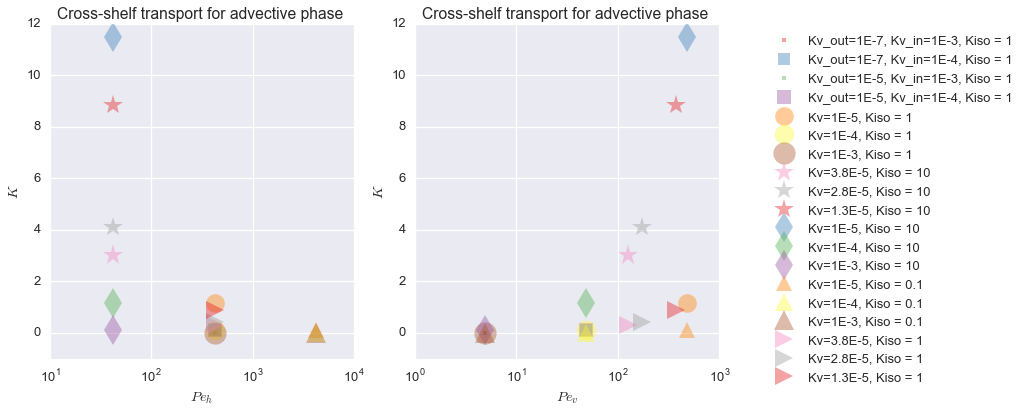

In [122]:
sns.set_palette( 'Set1',len(totalList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, totalList,verticalList):
    ax1 = plt.subplot(1,2,1)
    msize = (((np.exp(np.mean(tot[10:])/20)-19)**2)/10)+4
    plt.plot(Peh[ii] , K[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.4)
    plt.ylabel('$K$')
    plt.xlabel('$Pe_h$')
    plt.title('Cross-shelf transport for advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    ax1.set_ylim(-1,12)
    
    ax2 = plt.subplot(1,2,2)
    msize = (((np.exp(np.mean(tot[10:])/20)-19)**2)/10)+4
    plt.plot(Pev[ii] , K[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.4)
    plt.ylabel('$K$')
    plt.xlabel('$Pe_v$')
    plt.title('Cross-shelf transport for advective phase ')
    ax2.set_xscale("log", nonposy='clip')
    ax2.set_ylim(-1,12)
    
    jj = jj+1
    
    
ax2.legend(loc ='upper right', bbox_to_anchor=(2,1))

#ax2.legend(loc =0)
plt.show()

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


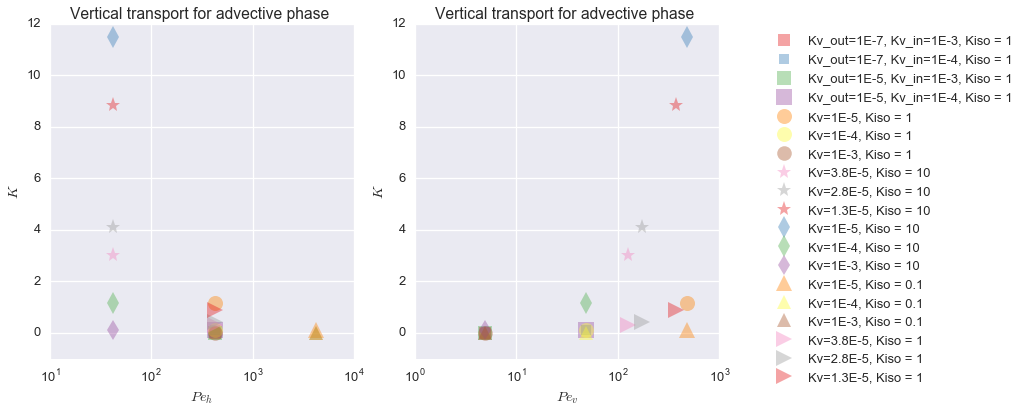

In [123]:
sns.set_palette( 'Set1',len(totalList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, totalList,verticalList):
    ax1 = plt.subplot(1,2,1)
    msize = (np.exp((np.mean(vert[10:])-0.6))*15)+2
    plt.plot(Peh[ii] , K[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.4)
    plt.ylabel('$K$')
    plt.xlabel('$Pe_h$')
    plt.title('Vertical transport for advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    ax1.set_ylim(-1,12)
    
    ax2 = plt.subplot(1,2,2)
    msize = (np.exp((np.mean(vert[10:])-0.6))*15)+2
    plt.plot(Pev[ii] , K[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.4)
    plt.ylabel('$K$')
    plt.xlabel('$Pe_v$')
    plt.title('Vertical transport for advective phase ')
    ax2.set_xscale("log", nonposy='clip')
    ax2.set_ylim(-1,12)
    
    jj = jj+1
    
    
ax2.legend(loc ='upper right', bbox_to_anchor=(2,1))

#ax2.legend(loc =0)
plt.show()